In [0]:
import numpy as np

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
# Torchvision
import torchvision
import torchvision.transforms as transforms

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import cifar10

(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar10.load_data()

x_train_cifar = x_train_cifar.reshape((x_train_cifar.shape[0], 3, 32, 32))
x_test_cifar = x_test_cifar.reshape((x_test_cifar.shape[0], 3, 32, 32))
y_train_cifar = y_train_cifar.reshape(-1)
y_test_cifar = y_test_cifar.reshape(-1)

#Get only first 1000 pictures for test
x_test_cifar=x_test_cifar[:1000]
y_test_cifar=y_test_cifar[:1000]

x_train_cifar = x_train_cifar.astype('float32')
x_test_cifar = x_test_cifar.astype('float32')
print("[cifar] x_train.shape={}, y_train.shape={}".format(x_train_cifar.shape, y_train_cifar.shape))
print("[cifar] x_test.shape={}, y_test.shape={}".format(x_test_cifar.shape, y_test_cifar.shape))

batch = 64

Using TensorFlow backend.


170500096/170498071 [==============================] - 3s 0us/step
[cifar] x_train.shape=(50000, 3, 32, 32), y_train.shape=(50000,)
[cifar] x_test.shape=(1000, 3, 32, 32), y_test.shape=(1000,)


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(), ])

trainloader_cifar = torch.utils.data.DataLoader(x_train_cifar, batch_size=batch,
                                          shuffle=True, num_workers=2)

testloader_cifar = torch.utils.data.DataLoader(x_test_cifar, batch_size=batch,
                                          shuffle=False, num_workers=2)

In [0]:
def train_cifar(epochs, net, criterion, optimizer, trainload, testloader, scheduler=None, verbose=True):
    start = time.time()
    net.to(device)
 
    for epoch in range(epochs):
        running_loss = 0.0
        net.train()
        for i, inputs_cifar in enumerate(trainload):
          
            img = Variable(inputs_cifar).to(device)
            _, outputs_cifar = net(img)
            loss = criterion(outputs_cifar, img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.data
            
            if verbose and i % 750 == 749:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 750))
                running_loss = 0.0

        running_loss_val = 0.0
        net.eval()
        for i, data in enumerate(testloader):

            images = data  
            images = Variable(images).to(device)
            decoded_imgs = net(images)[1]
            loss_val = criterion(decoded_imgs, images)
            running_loss_val += loss_val.data

            if verbose and i % 15 == 14:
                print('[%d, %5d] val_loss: %.3f' %
                      (epoch + 1, i + 1, running_loss_val / 15))
                running_loss_val = 0.0
        print("============================")
        if scheduler is not None:
            scheduler.step()
    end= time.time()
    print(f"Time cost for training (in seconds): {end-start} ")

In [0]:
class Autoencoder3_2D(nn.Module):
    def __init__(self, p):
        super(Autoencoder3_2D, self).__init__()
        
        self.encoder = nn.Sequential(
                        nn.Conv2d(3, 32, kernel_size=5),
                        nn.BatchNorm2d(32),
                        nn.ReLU(True),
                        nn.Dropout2d(p),

                        nn.Conv2d(32, 64, kernel_size=5),
                        nn.BatchNorm2d(64),
                        nn.ReLU(True),
                        nn.Dropout2d(p),


                        nn.Conv2d(64, 128, kernel_size=5),
                        nn.BatchNorm2d(128),
                        nn.ReLU(True),
                        nn.Dropout2d(p),

                        nn.Conv2d(128, 256, kernel_size=5),
                        nn.BatchNorm2d(256),
                        nn.ReLU(True),
                        nn.Dropout2d(p),

                        nn.Conv2d(256, 256, kernel_size=5),
                        nn.BatchNorm2d(256),
                        nn.ReLU(True)
        )
        
        self.decoder = nn.Sequential(

                        #nn.MaxUnpool2d(kernel_size=2),
                        nn.ConvTranspose2d(256, 256, kernel_size=5),
                        nn.BatchNorm2d(256),
                        nn.ReLU(True),
                        nn.Dropout2d(p),

                        nn.ConvTranspose2d(256, 128, kernel_size=5),
                        nn.BatchNorm2d(128),
                        nn.ReLU(True),
                        nn.Dropout2d(p),

                        nn.ConvTranspose2d(128, 64, kernel_size=5),
                        nn.ReLU(True),
                        nn.Dropout2d(p),

                        #nn.MaxUnpool2d(kernel_size=2, stride=2),
                        nn.ConvTranspose2d(64, 32, kernel_size=5),
                        nn.ReLU(True),
                        nn.Dropout2d(p),
                        
                        nn.ConvTranspose2d(32, 3, kernel_size=5),
                        nn.ReLU(True))
                        

        
    def forward(self,x):
        x_out = self.decoder(self.encoder(x))
        
        return _, x_out

Modeling with DropOut p = 0.25
[1,   750] loss: 4194.188
[1,    15] val_loss: 2998.027
[2,   750] loss: 3352.129
[2,    15] val_loss: 2632.060
[3,   750] loss: 3101.386
[3,    15] val_loss: 2480.334
[4,   750] loss: 2979.806
[4,    15] val_loss: 2297.582
[5,   750] loss: 2658.832
[5,    15] val_loss: 2019.817
[6,   750] loss: 2510.008
[6,    15] val_loss: 2319.939
[7,   750] loss: 2437.770
[7,    15] val_loss: 2005.906
[8,   750] loss: 2281.649
[8,    15] val_loss: 1880.798
[9,   750] loss: 2134.281
[9,    15] val_loss: 2008.654
[10,   750] loss: 2033.149
[10,    15] val_loss: 1391.752
[11,   750] loss: 1893.603
[11,    15] val_loss: 2021.577
[12,   750] loss: 1811.617
[12,    15] val_loss: 1726.922
[13,   750] loss: 1773.405
[13,    15] val_loss: 1442.298
[14,   750] loss: 1741.297
[14,    15] val_loss: 1428.571
[15,   750] loss: 1702.441
[15,    15] val_loss: 1385.477
[16,   750] loss: 1666.109
[16,    15] val_loss: 1474.670
[17,   750] loss: 1597.251
[17,    15] val_loss: 1448.361
[

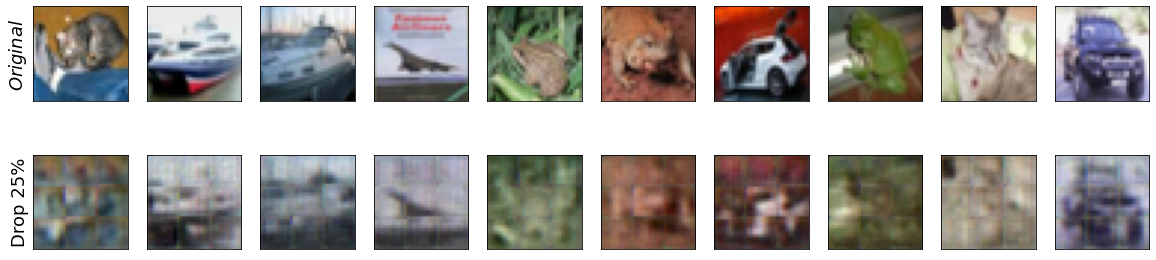

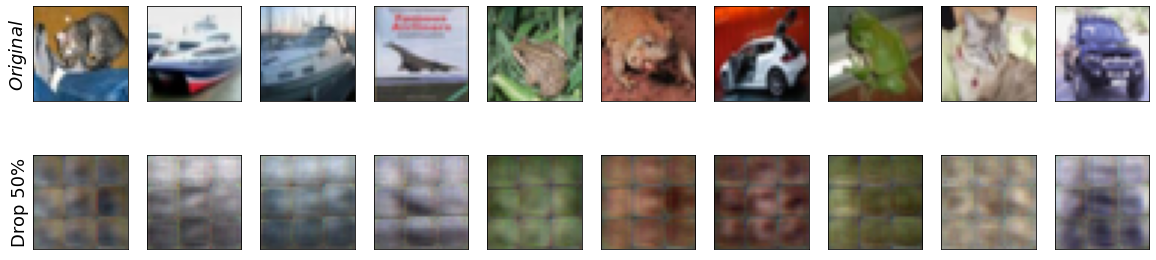

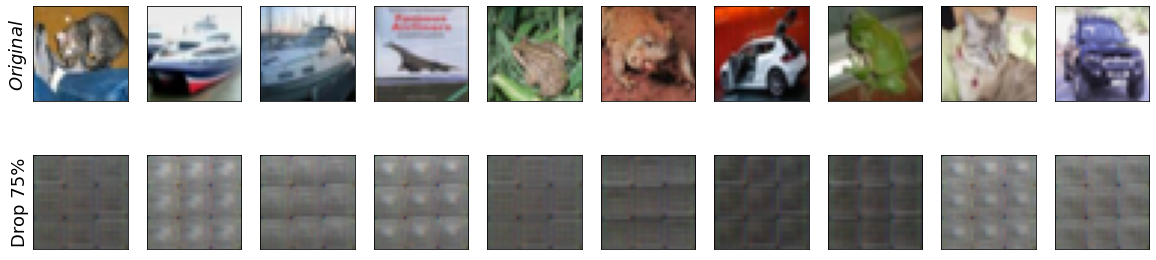

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

MSEs_cifar_2D = []

ps = [0.25, 0.5, 0.75]

for p in ps:
    print(f"Modeling with DropOut p = {p}")
    epochs = 50
    autoencoder_cifar2D = Autoencoder3_2D(p).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(autoencoder_cifar2D.parameters(), weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    train_cifar(epochs, autoencoder_cifar2D, criterion, optimizer, trainloader_cifar, testloader_cifar,  scheduler=scheduler, verbose=True)

    running_loss_val = 0.0
    i = 0
    decoded_pics = []
    reconstruction_time = []

    test_loader = torch.utils.data.DataLoader(x_test_cifar, batch_size=1, shuffle=False, num_workers=2)

    with torch.no_grad():
        for data in test_loader:
            images = data  
            images = Variable(images).to(device)
            i += 1
            encoded_imgs = autoencoder_cifar2D.encoder(images)
            start=time.time()
            decoded_imgs = autoencoder_cifar2D.decoder(encoded_imgs)
            end=time.time()
            reconstruction_time.append((end-start))
            decoded_pics.append(decoded_imgs)
            loss_val = criterion(decoded_imgs, images)
            running_loss_val += loss_val.data

    print(f'MSE of the tunned CNN AE on the 1000 test CIFAR images with dropout p = {p} is: {running_loss_val/i}')
    MSEs_cifar_2D.append(running_loss_val/i)

    fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))

    for X_test in testloader_cifar:
      for i in range(10):
          im = X_test[i,:]
          ax[0, i].imshow(im.numpy().reshape(32, 32, 3).astype(int));
          ax[1, i].imshow(decoded_pics[i].cpu().numpy().reshape(32, 32, 3).astype(int))
          ax[0, i].get_xaxis().set_ticks([])
          ax[0, i].get_yaxis().set_ticks([])
          ax[1, i].get_xaxis().set_ticks([])
          ax[1, i].get_yaxis().set_ticks([])

      break
    ax[0, 0].set_ylabel(f"$Original$",fontsize=18)
    ax[1, 0].set_ylabel(f"Drop {int(p*100)}%",fontsize=18)

In [9]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows, img_cols = 28, 28
x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)

#Get only first 1000 pictures for test
x_test=x_test[:1000]
y_test=y_test[:1000]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print("[mnist] x_train.shape={}, y_train.shape={}".format(x_train.shape, y_train.shape))
print("[mnist] x_test.shape={}, y_test.shape={}".format(x_test.shape, y_test.shape))

transform = transforms.Compose([transforms.ToTensor()])

trainloader_mnist = torch.utils.data.DataLoader(x_train, batch_size=64,
                                          shuffle=True, num_workers=2)

testloader_mnist = torch.utils.data.DataLoader(x_test, batch_size=64,
                                         shuffle=False, num_workers=2)

11493376/11490434 [==============================] - 10s 1us/step
[mnist] x_train.shape=(60000, 1, 28, 28), y_train.shape=(60000,)
[mnist] x_test.shape=(1000, 1, 28, 28), y_test.shape=(1000,)


In [0]:
def train(epochs, net, criterion, optimizer, trainload, testloader, scheduler=None, verbose=True):
    start = time.time()
    net.to(device)
 
    for epoch in range(epochs):
        running_loss = 0.0
        net.train()
        for i, inputs_mnist in enumerate(trainload):
          
            img = Variable(inputs_mnist).to(device)
            _, outputs_mnist = net(img)
            loss = criterion(outputs_mnist, img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.data
            
            if verbose and i % 900 == 899:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 900))
                running_loss = 0.0

        running_loss_val = 0.0
        net.eval()
        for i, data in enumerate(testloader):

            images = data  
            images = Variable(images).to(device)
            decoded_imgs = net(images)[1]
            loss_val = criterion(decoded_imgs, images)
            running_loss_val += loss_val.data

            if verbose and i % 15 == 14:
                print('[%d, %5d] val_loss: %.3f' %
                      (epoch + 1, i + 1, running_loss_val / 15))
                running_loss_val = 0.0
        print("============================")
        if scheduler is not None:
            scheduler.step()

    end = time.time()
    print(f"Time cost for training (in seconds): {end-start}")

In [11]:
from torch import device as device_
from torch.optim.lr_scheduler import StepLR

class Autoencoder3_MNIST_2D(nn.Module):
    def __init__(self, hid, p):
        super(Autoencoder3_MNIST_2D, self).__init__()
        
        self.encoder = nn.Sequential(
                        nn.Conv2d(1,4,kernel_size=5),
                        nn.BatchNorm2d(4),
                        nn.ReLU(True),
                        nn.Dropout2d(p),

                        nn.Conv2d(4, 12, kernel_size=5),
                        nn.BatchNorm2d(12),
                        nn.ReLU(True),
                        nn.Dropout2d(p),


                        nn.Conv2d(12, 16,kernel_size=5),
                        nn.BatchNorm2d(16),
                        nn.ReLU(True),
                        nn.Dropout2d(p),

                        nn.Conv2d(16,28, kernel_size=5),
                        nn.BatchNorm2d(28),
                        nn.ReLU(True),
                        nn.Dropout2d(p),

                        nn.Conv2d(28, 36, kernel_size=5),
                        nn.BatchNorm2d(36),
                        nn.ReLU(True),
                        nn.Dropout2d(p),

                        nn.Conv2d(36, hid, kernel_size=5),
                        nn.BatchNorm2d(hid),
                        nn.ReLU(True)
        )
        
        self.decoder = nn.Sequential(
                        nn.ConvTranspose2d(hid, 36, kernel_size=5),
                        nn.BatchNorm2d(36),
                        nn.ReLU(True),
                        nn.Dropout2d(p),

                        nn.ConvTranspose2d(36, 28, kernel_size=5),
                        nn.BatchNorm2d(28),
                        nn.ReLU(True),
                        nn.Dropout2d(p),
 
                        #nn.MaxUnpool2d(kernel_size=2),
                        nn.ConvTranspose2d(28, 16, kernel_size=5),
                        nn.ReLU(True),
                        nn.Dropout2d(p),

                        nn.ConvTranspose2d(16, 12, kernel_size=5),
                        nn.ReLU(True),
                        nn.Dropout2d(p),

                        nn.ConvTranspose2d(12, 4, kernel_size=5),
                        nn.ReLU(True),
                        nn.Dropout2d(p),

                        #nn.MaxUnpool2d(kernel_size=2, stride=2),
                        nn.ConvTranspose2d(4, 1, kernel_size=5),
                        nn.ReLU(True))

        
    def forward(self,x):
        x_out = self.decoder(self.encoder(x))
        
        return _, x_out

ERROR! Session/line number was not unique in database. History logging moved to new session 59


Modeling with DropOut p = 0
[1,   900] loss: 1288.693
[1,    15] val_loss: 511.047
[2,   900] loss: 497.099
[2,    15] val_loss: 428.417
[3,   900] loss: 393.609
[3,    15] val_loss: 317.699
[4,   900] loss: 332.259
[4,    15] val_loss: 263.581
[5,   900] loss: 290.168
[5,    15] val_loss: 233.432
[6,   900] loss: 261.570
[6,    15] val_loss: 209.590
[7,   900] loss: 236.862
[7,    15] val_loss: 201.676
[8,   900] loss: 220.246
[8,    15] val_loss: 196.351
[9,   900] loss: 207.378
[9,    15] val_loss: 173.908
[10,   900] loss: 193.217
[10,    15] val_loss: 166.450
[11,   900] loss: 183.140
[11,    15] val_loss: 167.175
[12,   900] loss: 176.035
[12,    15] val_loss: 146.743
[13,   900] loss: 167.290
[13,    15] val_loss: 150.119
[14,   900] loss: 161.992
[14,    15] val_loss: 135.480
[15,   900] loss: 154.669
[15,    15] val_loss: 130.856
[16,   900] loss: 148.470
[16,    15] val_loss: 126.102
[17,   900] loss: 143.060
[17,    15] val_loss: 123.742
[18,   900] loss: 138.937
[18,    15]

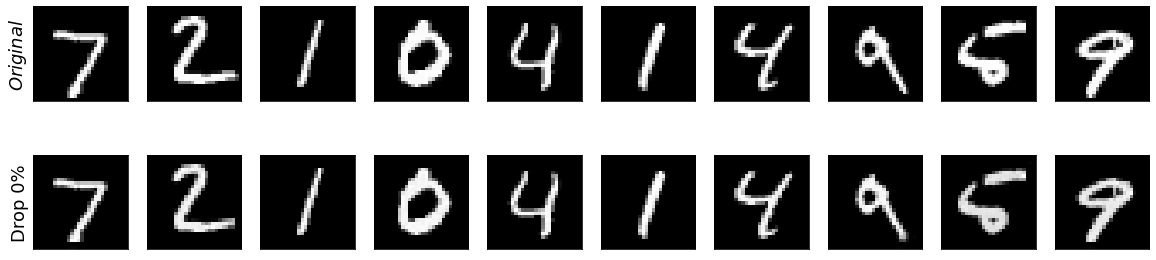

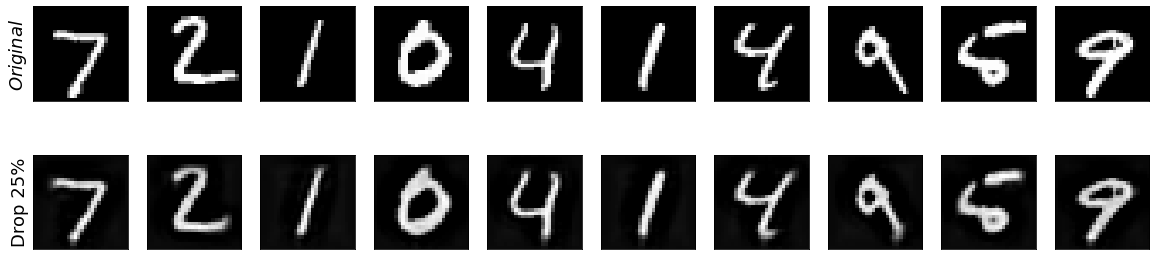

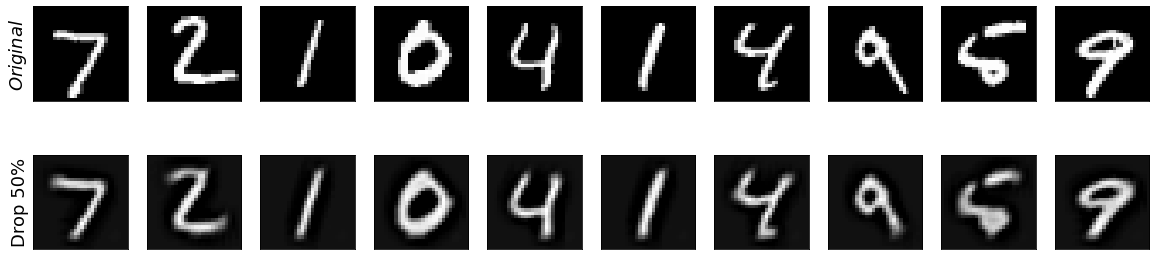

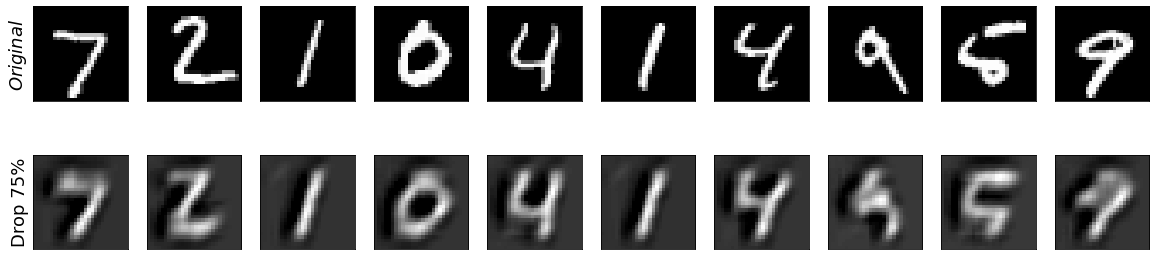

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

MSEs = []

ps = [0, 0.25, 0.5, 0.75]

for p in ps:
    print(f"Modeling with DropOut p = {p}")
    net = Autoencoder3_MNIST_2D(72, p).to(device)
    optimizer2 = torch.optim.Adam(net.parameters(), weight_decay=1e-5)
    criterion = nn.MSELoss().to(device)
    epochs = 200
    scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer2, epochs)
    train(epochs, net, criterion, optimizer2, trainloader_mnist, testloader_mnist,  scheduler=scheduler2, verbose=True)

    running_loss_val = 0.0
    i = 0
    reconstruction_time = []
    decoded_pics = []
    testloader = torch.utils.data.DataLoader(x_test, batch_size=1,
                                            shuffle=False, num_workers=2)

    with torch.no_grad():
        for data in testloader:
            images = data  
            images = Variable(images).to(device)
            i += 1
            encoded_imgs = net.encoder(images)
            start=time.time()
            decoded_imgs = net.decoder(encoded_imgs)
            end=time.time()
            reconstruction_time.append(end-start)
            decoded_pics.append(decoded_imgs)
            loss_val = criterion(decoded_imgs, images)
            running_loss_val += loss_val.data

    print(f'MSE of the tunned CNN AE on the 1000 test MNIST images with dropout p = {p} is: {running_loss_val/i}')
    MSEs.append(running_loss_val/i)

    fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))

    for X_test in testloader_mnist:
      for i in range(10):
          im = X_test[i,:]
          ax[0, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray');
          ax[1, i].imshow(decoded_pics[i].cpu().numpy().reshape(28, 28).astype(int), cmap='gray')
          ax[0, i].get_xaxis().set_ticks([])
          ax[0, i].get_yaxis().set_ticks([])
          ax[1, i].get_xaxis().set_ticks([])
          ax[1, i].get_yaxis().set_ticks([])

      break
    ax[0, 0].set_ylabel(f"$Original$",fontsize=18)
    ax[1, 0].set_ylabel(f"Drop {int(p*100)}%",fontsize=18)